# Detroit study
## Determine blighted buildings in the city

In this project, our goal is to build a model able to determine if a building will be consider as blighted, based on his events history.

We know the history of a tons of locations in Detroit and also an history of blighted buildings.
As extra resources, we will use the list of 311 calls, crime history and violations.

In [3]:
import pandas as pd
import numpy as np
from datetime import datetime

## Determine buildings in the city

In this part, we've to determine a list of all he buildings in the city.
To perform that, we use all the resources we own and build clusters of events to determine an exhaustive list of buildings in the city.


### Data grouping for location detection

In [ ]:
data = pd.read_csv('detroit-311.csv')
data2 = pd.read_csv('detroit-blight-violations.csv')
data3 = pd.read_csv('detroit-crime.csv')
data4 = pd.read_csv('detroit-demolition-permits.tsv', sep='\t')

In [197]:
locationsData3 = pd.concat([data3['LAT'], data3['LON']], axis=1)
locationsData3.columns = ['lat', 'lng']

locationsData2 = pd.DataFrame(columns={'lat', 'lng'})
def parseAddress(dirtyAddress):
    try:
        addressData = dirtyAddress.split('\n')
        lat = addressData[2][1:-1].split(',')[0].strip()
        lng = addressData[2][1:-1].split(',')[1].strip()
        return pd.Series([lat, lng])
    except:
        pass

locationsData2A = data2.apply(lambda row:parseAddress(row['ViolationAddress']),axis=1)
locationsData2B = data2.apply(lambda row:parseAddress(row['MailingAddress']),axis=1)
locationsData2A.columns = ['lat', 'lng']
locationsData2B.columns = ['lat', 'lng']


locationsData4A = data4.apply(lambda row:parseAddress(row['site_location']),axis=1)
locationsData4B = data4.apply(lambda row:parseAddress(row['owner_location']),axis=1)
locationsData4C = data4.apply(lambda row:parseAddress(row['contractor_location']),axis=1)
locationsData4A.columns = ['lat', 'lng']
locationsData4B.columns = ['lat', 'lng']
locationsData4C.columns = ['lat', 'lng']

locationsData =  pd.concat([data['lat'], data['lng']], axis=1)

In [198]:
locations = pd.DataFrame(columns={'lat', 'lng'})
locations = locations.append(locationsData, ignore_index=True)
locations = locations.append(locationsData2A, ignore_index=True)
locations = locations.append(locationsData2B, ignore_index=True)
locations = locations.append(locationsData3, ignore_index=True)
locations = locations.append(locationsData4A, ignore_index=True)
locations = locations.append(locationsData4B, ignore_index=True)
locations = locations.append(locationsData4C, ignore_index=True)

In [199]:
locations.count()

lat    770942
lng    770942
dtype: int64

In [200]:
locations['lat'] = pd.to_numeric(locations['lat'], errors='raise') 
locations['lng'] = pd.to_numeric(locations['lng'], errors='raise') 
locations.to_csv('./locations.csv', index=False)

#### We now have a complete list of uniques lat/lng of locations in the city and around.

In [2]:
locations = pd.read_csv('./locations.csv')

### Format and clean data

In [4]:
locations['lat'] = locations.apply(lambda row:np.round(row['lat'], 5),axis=1)
locations['lng'] = locations.apply(lambda row:np.round(row['lng'], 5),axis=1)

In [17]:
locations = locations.drop_duplicates()

In [19]:
locations = locations[(locations['lat'] > 23) & (locations['lat'] < 50)]
locations['lat'].describe()

count    264401.000000
mean         42.259709
std           1.149134
min          24.550520
25%          42.359050
50%          42.393900
75%          42.423900
max          48.792170
Name: lat, dtype: float64

In [20]:
locations = locations[(locations['lng'] < -64) & (locations['lng'] > -132)]
locations['lng'].describe()

count    264399.000000
mean        -83.392738
std           3.151343
min        -124.174110
25%         -83.200370
50%         -83.127700
75%         -83.032930
max         -69.298540
Name: lng, dtype: float64

In [24]:
locations = locations.reset_index()

### Run DBScan to discover right locations

We use DBScan algorithm to create clusters of buildings based on locations.
We discovered  ~ 200K locations over ~ 800K sparsed locations

In [25]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler

In [26]:
test_data = locations
X = pd.concat([test_data['lat'], test_data['lng']], axis=1).as_matrix()

In [27]:
# Compute DBSCAN
db = DBSCAN(eps=0.0001, min_samples=1).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

In [28]:
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print('Estimated number of clusters: %d' % n_clusters_)

Estimated number of clusters: 200969


### Populate blocs ids

In [30]:
def populateBlocs(row):
    #print row.name, labels[(row.name)], (row.name)
    try:
        return labels[(row.name)]
    except:
        pass

locations['bloc_id'] = locations.apply(populateBlocs, axis=1)

In [31]:
locations = locations.drop('index', axis=1)

In [32]:
locations.to_csv('./locations_buildings',index=False)

In [33]:
locations.count()

lat        264399
lng        264399
bloc_id    264399
dtype: int64

### Regroup locations and blocs

Based on the locations, we define buildings with a local search around them.

In [21]:
# precision +0.00009999999, -0.00009999999

In [34]:
groupedLocations = locations.groupby('bloc_id', as_index=False)
latitudes = groupedLocations['lat'].describe()
longitudes = groupedLocations['lng'].describe()

In [36]:
latitudes = latitudes.rename(columns = {
        'mean': 'lat_mean',
        'min': 'lat_min',
        'max': 'lat_max',
    })

In [37]:
longitudes = longitudes.rename(columns = {
        'mean': 'lng_mean',
        'min': 'lng_min',
        'max': 'lng_max',
    })

In [38]:
mergedCoordinates = pd.concat([latitudes, longitudes], axis=1)

def getBlocBoxes(row):
    return pd.Series([
            row.name, 
            row['lat_mean'], 
            row['lng_mean'], 
            row['lat_min'], 
            row['lat_max'], 
            row['lng_min'], 
            row['lng_max'] 
        ])
    
coordinates = mergedCoordinates.apply(getBlocBoxes, axis=1)
coordinates.columns = ['bloc_id', 'lat_center', 'lng_center', 'lat_min', 'lat_max', 'lng_min', 'lng_max']
coordinates.head()

,bloc_id,lat_center,lng_center,lat_min,lat_max,lng_min,lng_max
0,0.0,42.384017,-83.161034,42.38388,42.38415,-83.16107,-83.16095
1,1.0,42.440470,-83.080920,42.44047,42.44047,-83.08092,-83.08092
2,2.0,42.445240,-82.962040,42.44524,42.44524,-82.96204,-82.96204
3,3.0,42.421037,-83.166245,42.42100,42.42106,-83.16630,-83.16619
4,4.0,42.402030,-83.162870,42.40203,42.40203,-83.16287,-83.16287


As you see above, a building is now define by a center and four delimitation points.

In [42]:
coordinates.count()

bloc_id       200969
lat_center    200969
lng_center    200969
lat_min       200969
lat_max       200969
lng_min       200969
lng_max       200969
dtype: int64

In [41]:
coordinates.to_csv('./blocs.csv', index=False)

In [379]:
coordinates = pd.read_csv('./blocs.csv')

### Test the bloc finder from lat/lng

We define a function to retrieve a list of blocs from coordinates.

In [387]:
def getBlocs(x, y):
    go = True
    precision = 1e-08
    while (go or len(coords) < 1):
        
        coords = coordinates[
            (np.isclose(coordinates['lat_center'], x, rtol=precision, atol=1e-05)) &
            (np.isclose(coordinates['lng_center'],y, rtol=precision, atol=1e-05))
        ]
        
        precision *= 10
        if precision >= 1e-04:
            break

        go = False
    
    precision = 1e-08
    while (len(coords) < 1):
        
        coords = coordinates[
            (np.isclose(coordinates['lat_min'], x, rtol=precision, atol=1e-05)) &
            (np.isclose(coordinates['lat_max'],x, rtol=precision, atol=1e-05)) &
            (np.isclose(coordinates['lng_min'], y, rtol=precision, atol=1e-05)) &
            (np.isclose(coordinates['lng_max'],y, rtol=precision, atol=1e-05))
        ]
        
        precision *= 10
        if precision >= 1e-04:
            return 0

    return list(set(coords['bloc_id']))[0]

#### Testing

In [44]:
results = getBlocs(42.440, -83.08)
print results

set([41024.0, 187488.0, 45378.0, 43783.0, 75101.0, 150512.0, 135985.0, 191985.0, 60379.0, 35677.0, 40959.0])


## Study demolition permits

We extract a list of blighted building from the demolition permits list.
Then, we will define an equivalent list of non blighted buildings.
That will be our base for a training dataset.

In [380]:
permits = pd.read_csv('detroit-demolition-permits.tsv', sep='\t')

In [381]:
permits['BLD_PERMIT_TYPE'].value_counts()

DISM         5859
Dismantle    1274
Name: BLD_PERMIT_TYPE, dtype: int64

In [382]:
def parseAddress(dirtyAddress):
    try:
        addressData = dirtyAddress.split('\n')
        lat = addressData[2][1:-1].split(',')[0].strip()
        lng = addressData[2][1:-1].split(',')[1].strip()
        return pd.Series([lat, lng])
    except:
        return pd.Series([0, 0])



In [383]:
blightedPlaces = permits.apply(lambda row:parseAddress(row['site_location']),axis=1)
blightedPlaces.columns = ['lat', 'lng']

In [384]:
blightedPlaces = blightedPlaces[(blightedPlaces['lat'] > 0) & (blightedPlaces['lng'] > 0)]
blightedPlaces.count()

lat    6275
lng    6275
dtype: int64

In [385]:
blightedPlaces['lat'] = pd.to_numeric(blightedPlaces['lat'], errors='raise') 
blightedPlaces['lng'] = pd.to_numeric(blightedPlaces['lng'], errors='raise') 

In [386]:
coordinates.head()

,bloc_id,lat_center,lng_center,lat_min,lat_max,lng_min,lng_max
0,0.0,42.384017,-83.161034,42.38388,42.38415,-83.16107,-83.16095
1,1.0,42.440470,-83.080920,42.44047,42.44047,-83.08092,-83.08092
2,2.0,42.445240,-82.962040,42.44524,42.44524,-82.96204,-82.96204
3,3.0,42.421037,-83.166245,42.42100,42.42106,-83.16630,-83.16619
4,4.0,42.402030,-83.162870,42.40203,42.40203,-83.16287,-83.16287


### Retrieve blocs for all places

In [388]:
blightedPlaces['bloc_id'] = blightedPlaces.apply(lambda row: getBlocs(row['lat'], row['lng']), axis=1)

In [389]:
diff = coordinates[~coordinates.bloc_id.isin(blightedPlaces['bloc_id'])]

In [498]:
notBlightedPlaces = diff.sample(len(blightedPlaces.index))

In [525]:
notBlightedPlaces.count()

bloc_id    6275
label      6275
dtype: int64

### Setup dataset for ML training

In [521]:
training = pd.concat([blightedPlaces['bloc_id']], axis=1)
training['label'] = 'blighted'

In [524]:
notBlightedPlaces = pd.concat([notBlightedPlaces['bloc_id']], axis=1)
notBlightedPlaces['label'] = 'notblighted'

In [526]:
training = training.append(notBlightedPlaces, ignore_index=True)

In [527]:
training.count()

bloc_id    12550
label      12550
dtype: int64

In [567]:
training.to_csv('./training2.csv', index=False)

In [504]:
training = pd.read_csv('training2.csv')

## First checkpoint in the project

We now have a reasonable sized dataset of building from the city of Detroit;
Our goal is know to enrich it with enough features to be relevant for training.

## Study blight violations

In [66]:
violations = pd.read_csv('detroit-blight-violations.csv')

In [67]:
violations.head()

,TicketID,TicketNumber,AgencyName,ViolName,ViolationStreetNumber,ViolationStreetName,MailingStreetNumber,MailingStreetName,MailingCity,MailingState,MailingZipCode,NonUsAddressCode,Country,TicketIssuedDT,TicketIssuedTime,HearingDT,CourtTime,ViolationCode,ViolDescription,Disposition,FineAmt,AdminFee,LateFee,StateFee,CleanUpCost,JudgmentAmt,PaymentStatus,Void,ViolationCategory,ViolationAddress,MailingAddress
0,26288,05000001DAH,Department of Public Works,"Group, LLC, Grand Holding",2566,GRAND BLVD,743,"Beaubien, Ste. 201",Detroit,MI,48226,NaN,NaN,01/01/38440 12:00:00 AM,12:00:00,01/01/38474 12:00:00 AM,9:00AM,22-2-20,Burning solid waste in open fires,Responsible By Determination,$1500.00,$20.00,$150.00,$10.00,$0.00,$1680.00,PAID IN FULL,0.0,0,"2566 GRAND BLVD\nDetroit, MI\n(42.363182370000...","743 Beaubien\nDetroit, MI 48226\n(42.333730630..."
1,19800,05000025DAH,Department of Public Works,"JACKSON, RAECHELLE",19014,ASHTON,20501,HEYDEN,DETROIT,MI,48219,NaN,NaN,01/01/38383 12:00:00 AM,10:15:00,01/01/38425 12:00:00 AM,1:30PM,22-2-22,Bulk solid waste deposited more than 24 hours ...,Not responsible By Determination,$100.00,$20.00,$10.00,$10.00,$0.00,$140.00,NO PAYMENT APPLIED,0.0,0,"19014 ASHTON\nDetroit, MI\n(42.429390762000025...","20501 HEYDEN\nDETROIT, MI 48219\n(42.442177633..."
2,19804,05000026DAH,Department of Public Works,"TALTON, CAROL ANN",18735,STAHELIN,18735,STAHELI N,DETROIT,MI,48219,NaN,NaN,01/01/38383 12:00:00 AM,10:35:00,01/01/38425 12:00:00 AM,1:30PM,22-2-22,Bulk solid waste deposited more than 24 hours ...,Responsible By Determination,$100.00,$20.00,$10.00,$10.00,$0.00,$140.00,PAID IN FULL,0.0,0,"18735 STAHELIN\nDetroit, MI\n(42.4287074590000...","18735 STAHELI N\nDETROIT, MI 48219\n(42.428707..."
3,20208,05000027DAH,Department of Public Works,"BONNER, DARRYL E.",20125,MONICA,25335,PEEKSKILL,SOUTHFIELD,MI,48043,NaN,NaN,01/01/38385 12:00:00 AM,10:45:00,01/01/38422 12:00:00 AM,1:30PM,22-2-45,Violation of time limit for approved container...,Responsible By Default,$100.00,$20.00,$10.00,$10.00,$0.00,$140.00,NO PAYMENT APPLIED,0.0,0,"20125 MONICA\nDetroit, MI\n(42.44169828400004,...","25335 PEEKSKILL\nSOUTHFIELD, MI 48043\n(42.475..."
4,20211,05000028DAH,Department of Public Works,"GREGORY, JAMES LEE",17397,PRAIRIE,17397,PRAIRIE,DETROIT,MI,48221,NaN,NaN,01/01/38385 12:00:00 AM,11:10:00,01/01/38422 12:00:00 AM,1:30PM,22-2-22,Bulk solid waste deposited more than 24 hours ...,Responsible By Default,$100.00,$20.00,$10.00,$10.00,$0.00,$140.00,PAID IN FULL,0.0,0,"17397 PRAIRIE\nDetroit, MI\n(42.42031769500005...","17397 PRAIRIE\nDETROIT, MI 48221\n(42.42031769..."


### Analysis results

After some graphs and study, we concluded that we've a lot of useful informations in this document.
We selected some of them. Costs related data of a violation seems to be the most interesting stuf here.
By the way , we'll try to extract more data around the payment status which could be consider as a good factor for a blighted building and maybe also the violation category (0 or 1 mainly)

In [91]:
cleandedViolations = pd.concat([violations['AgencyName'], violations['ViolationCode'], violations['FineAmt']
                                , violations['StateFee'], violations['CleanUpCost'], violations['JudgmentAmt']
                                ,violations['PaymentStatus'], violations['ViolationCategory'], violations['ViolationAddress']]
                               , axis=1)

In [92]:
cleandedViolations.head()

,AgencyName,ViolationCode,FineAmt,StateFee,CleanUpCost,JudgmentAmt,PaymentStatus,ViolationCategory,ViolationAddress
0,Department of Public Works,22-2-20,$1500.00,$10.00,$0.00,$1680.00,PAID IN FULL,0,"2566 GRAND BLVD\nDetroit, MI\n(42.363182370000..."
1,Department of Public Works,22-2-22,$100.00,$10.00,$0.00,$140.00,NO PAYMENT APPLIED,0,"19014 ASHTON\nDetroit, MI\n(42.429390762000025..."
2,Department of Public Works,22-2-22,$100.00,$10.00,$0.00,$140.00,PAID IN FULL,0,"18735 STAHELIN\nDetroit, MI\n(42.4287074590000..."
3,Department of Public Works,22-2-45,$100.00,$10.00,$0.00,$140.00,NO PAYMENT APPLIED,0,"20125 MONICA\nDetroit, MI\n(42.44169828400004,..."
4,Department of Public Works,22-2-22,$100.00,$10.00,$0.00,$140.00,PAID IN FULL,0,"17397 PRAIRIE\nDetroit, MI\n(42.42031769500005..."


#### We've to convert all the currency data into float to be able to handle it.

In [93]:
def toDollar(dollar):
    try:
        return float(dollar[1:])
    except:
        return 0

cleandedViolations['StateFee'] = cleandedViolations.apply(lambda row: toDollar(row['StateFee']), axis=1)
cleandedViolations['CleanUpCost'] = cleandedViolations.apply(lambda row: toDollar(row['CleanUpCost']), axis=1)
cleandedViolations['JudgmentAmt'] = cleandedViolations.apply(lambda row: toDollar(row['JudgmentAmt']), axis=1)
cleandedViolations['FineAmt'] = cleandedViolations.apply(lambda row: toDollar(row['FineAmt']), axis=1)
cleandedViolations.head()

,AgencyName,ViolationCode,FineAmt,StateFee,CleanUpCost,JudgmentAmt,PaymentStatus,ViolationCategory,ViolationAddress
0,Department of Public Works,22-2-20,1500.0,10.0,0.0,1680.0,PAID IN FULL,0,"2566 GRAND BLVD\nDetroit, MI\n(42.363182370000..."
1,Department of Public Works,22-2-22,100.0,10.0,0.0,140.0,NO PAYMENT APPLIED,0,"19014 ASHTON\nDetroit, MI\n(42.429390762000025..."
2,Department of Public Works,22-2-22,100.0,10.0,0.0,140.0,PAID IN FULL,0,"18735 STAHELIN\nDetroit, MI\n(42.4287074590000..."
3,Department of Public Works,22-2-45,100.0,10.0,0.0,140.0,NO PAYMENT APPLIED,0,"20125 MONICA\nDetroit, MI\n(42.44169828400004,..."
4,Department of Public Works,22-2-22,100.0,10.0,0.0,140.0,PAID IN FULL,0,"17397 PRAIRIE\nDetroit, MI\n(42.42031769500005..."


In [94]:
cleandedViolations.to_csv('./cleandedViolations.csv', index=False)

#### As usual, we parsed addresses to find locations, then, associated buildings (from our first location dataset)

In [95]:
violationsCoords = cleandedViolations.apply(lambda row:parseAddress(row['ViolationAddress']),axis=1)

In [96]:
violationsCoords.columns = ['lat', 'lng']

In [99]:
violationsCoords['lat'] = pd.to_numeric(violationsCoords['lat'], errors='raise') 
violationsCoords['lng'] = pd.to_numeric(violationsCoords['lng'], errors='raise') 
violationsCoords['lat'] = violationsCoords.apply(lambda row:np.round(row['lat'], 5),axis=1)
violationsCoords['lng'] = violationsCoords.apply(lambda row:np.round(row['lng'], 5),axis=1)

In [18]:
coordinates = pd.read_csv('blocs.csv')

In [102]:
violationsCoords.count()

lat    307804
lng    307804
dtype: int64

In [90]:
#testData = violationsCoords[50:100]
violations['bloc_id'] = violations.apply(lambda row: getBlocs(row['lat'], row['lng']), axis=1)

In [107]:
violations = pd.concat([cleandedViolations, violationsCoords], axis=1)

#### As an extra feature, we would like to keep a part of the violation code for each violation. Maybe we've some more important than others; classify them could have an interest.

In [12]:
def getViolationsCodeDetails(violationCode):
    details = violationCode.split('-')
    
    data = {}
    if len(details) > 0 and details[0] is not None:
        data['violationCode-0'] = details[0]
        
    if len(details) > 1 and details[1] is not None:
        data['violationCode-1'] = details[1]
    if len(details) > 2 and details[2] is not None:
        data['violationCode-2'] = details[2]
    
    if len(data) > 0:
        return pd.Series(data)
    else:
        print details
        pass
    

violations = violations.merge(violations.ViolationCode.apply(lambda row: getViolationsCodeDetails(row)), 
    left_index=True, right_index=True)

violations.head()

,AgencyName,ViolationCode,FineAmt,StateFee,CleanUpCost,JudgmentAmt,PaymentStatus,ViolationCategory,ViolationAddress,lat,lng,violationCode-0,violationCode-1,violationCode-2
0,Department of Public Works,22-2-20,1500.0,10.0,0.0,1680.0,PAID IN FULL,0,"2566 GRAND BLVD\nDetroit, MI\n(42.363182370000...",42.363182,-83.091677,22,2,20
1,Department of Public Works,22-2-22,100.0,10.0,0.0,140.0,NO PAYMENT APPLIED,0,"19014 ASHTON\nDetroit, MI\n(42.429390762000025...",42.429391,-83.220394,22,2,22
2,Department of Public Works,22-2-22,100.0,10.0,0.0,140.0,PAID IN FULL,0,"18735 STAHELIN\nDetroit, MI\n(42.4287074590000...",42.428707,-83.227548,22,2,22
3,Department of Public Works,22-2-45,100.0,10.0,0.0,140.0,NO PAYMENT APPLIED,0,"20125 MONICA\nDetroit, MI\n(42.44169828400004,...",42.441698,-83.145018,22,2,45
4,Department of Public Works,22-2-22,100.0,10.0,0.0,140.0,PAID IN FULL,0,"17397 PRAIRIE\nDetroit, MI\n(42.42031769500005...",42.420318,-83.145328,22,2,22


### Aggregate data by bloc id

In [450]:
violations = pd.read_csv('./violations_blocs.csv')

In [451]:
len(violations['bloc_id'].unique())

71692

#### We keep only the first part of the violation code. Also, we don't need anymore the original one and the location, 'cause we've the building id.

In [452]:
violations = violations.drop('ViolationCode', axis=1)
violations = violations.drop('violationCode-1', axis=1)
violations = violations.drop('violationCode-2', axis=1)
violations = violations.drop('ViolationAddress', axis=1)

In [453]:
groupedViolations = violations.groupby('bloc_id', as_index=False)
violations['nb_violations'] = 0

In [454]:
violations.to_csv('./violations_blocs.csv', index=False)

#### Here we aggregate the data by bloc id and consider to trade of some information which could be hard to manage in a modelisation.

In [455]:
groupedViolationsAgg = groupedViolations.agg({
        'AgencyName': 'first',
        'violationCode-0': 'first',
        'FineAmt': 'sum',
        'StateFee': 'sum',
        'CleanUpCost': 'sum',
        'JudgmentAmt': 'sum',
        'PaymentStatus': 'first',
        'ViolationCategory': 'first',
        'nb_violations': 'count'
    })

In [456]:
groupedViolationsAgg.head()

,bloc_id,CleanUpCost,FineAmt,nb_violations,AgencyName,JudgmentAmt,StateFee,violationCode-0,ViolationCategory,PaymentStatus
0,0.0,0.0,550.0,2,Department of Public Works,665.0,20.0,22,0,NO PAYMENT APPLIED
1,1.0,0.0,50.0,1,Department of Public Works,85.0,10.0,9,0,NO PAYMENT APPLIED
2,28.0,0.0,200.0,1,Department of Public Works,250.0,10.0,22,0,NO PAYMENT APPLIED
3,32.0,0.0,1800.0,5,Building and Safety Engineering Department,2130.0,50.0,9,0,PAID IN FULL
4,37.0,320.0,3500.0,7,Building and Safety Engineering Department,4060.0,70.0,9,0,NO PAYMENT APPLIED


## Adds 311 calls

We simply added the necessary information from 311 calls.
We've already selected only few columns from this document and added the count per building.

In [459]:
calls = pd.read_csv('./311_blocs.csv')
calls['nb_calls'] = 0

In [460]:
groupedCalls = calls.groupby('bloc_id', as_index=False)

In [461]:
groupedCallsAgg = groupedCalls.agg({
        'issue_type': 'last',
        'rating': 'min',
        'ticket_status': 'last',
        'nb_calls': 'count'
    })

## Adds crimes

We simply added the necessary information from crimes registered.
We've already selected only few columns from this document and added the count per building.

In [467]:
crimes = pd.read_csv('./crimes_blocs.csv')
crimes['nb_crimes'] = 0

In [468]:
groupedCrimes = crimes.groupby('bloc_id', as_index=False)

In [469]:
groupedCrimesAgg = groupedCrimes.agg({
        'STATEOFFENSEFILECLASS': 'last',
        'nb_crimes': 'count'
    })

## Merge all data

In [528]:
data = pd.merge(training, groupedViolationsAgg, on='bloc_id', how='left')
#data = data.fillna(0)

In [529]:
data.to_csv('./data_train_with_violations.csv', index=False)

In [530]:
data = pd.merge(data, groupedCallsAgg, on='bloc_id', how='left')
#data = data.fillna(0)

In [531]:
data.to_csv('./data_train_with_violations_and_calls.csv', index=False)

In [532]:
data = pd.merge(data, groupedCrimesAgg, on='bloc_id', how='left')
#data = data.fillna(0)

In [533]:
data.to_csv('./data_train_with_violations_and_calls_and_crimes.csv', index=False)

In [534]:
data = pd.read_csv('./data_train_with_violations_and_calls_and_crimes.csv')

### Here we fill all the NA with basics informations (arbitrary selected).
We could have done some ML to determine better informations to feed instead.

In [538]:
data['CleanUpCost'] = data['CleanUpCost'].fillna(0)
data['FineAmt'] = data['FineAmt'].fillna(0)
data['nb_violations'] = data['nb_violations'].fillna(0)
data['nb_calls'] = data['nb_calls'].fillna(0)
data['nb_crimes'] = data['nb_crimes'].fillna(0)
data['AgencyName'] = data['AgencyName'].fillna(-1)
data['JudgmentAmt'] = data['JudgmentAmt'].fillna(0)
data['StateFee'] = data['StateFee'].fillna(0)
data['violationCode-0'] = data['violationCode-0'].fillna(-1)
data['ViolationCategory'] = data['ViolationCategory'].fillna(-1)
data['PaymentStatus'] = data['PaymentStatus'].fillna(-1)
data['STATEOFFENSEFILECLASS'] = data['STATEOFFENSEFILECLASS'].fillna(-1)
data['rating'] = data['rating'].fillna(-1)
data['ticket_status'] = data['ticket_status'].fillna(-1)
data['issue_type'] = data['issue_type'].fillna(-1)

In [539]:
data.isnull().sum(axis=1).value_counts()

0    12550
dtype: int64

In [540]:
data.head(5)

,bloc_id,label,CleanUpCost,FineAmt,nb_violations,AgencyName,JudgmentAmt,StateFee,violationCode-0,ViolationCategory,PaymentStatus,rating,nb_calls,ticket_status,issue_type,STATEOFFENSEFILECLASS,nb_crimes
0,80884.0,blighted,0.0,600.0,2.0,Detroit Police Department,720.0,20.0,9,0.0,NO PAYMENT APPLIED,-1.0,0.0,-1,-1,-1.0,0.0
1,52539.0,blighted,0.0,2550.0,9.0,Building and Safety Engineering Department,3075.0,90.0,9,0.0,NO PAYMENT APPLIED,-1.0,0.0,-1,-1,35001.0,1.0
2,199492.0,blighted,0.0,0.0,0.0,-1,0.0,0.0,-1,-1.0,-1,-1.0,0.0,-1,-1,-1.0,0.0
3,199493.0,blighted,0.0,0.0,0.0,-1,0.0,0.0,-1,-1.0,-1,-1.0,0.0,-1,-1,-1.0,0.0
4,199494.0,blighted,0.0,0.0,0.0,-1,0.0,0.0,-1,-1.0,-1,-1.0,0.0,-1,-1,-1.0,0.0


### Define a total charge feature and save our training dataset

In [541]:
data['total_charges'] = data['CleanUpCost'] + data['FineAmt'] + data['JudgmentAmt'] + data['StateFee']

In [566]:
data.to_csv('./data_train.csv', index=False)

In [4]:
data = pd.read_csv('./data_train.csv')

## Machine learning

### Labelize data

In [5]:
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

#### We use a multilabel encoder to go faster with the data encoding.

In [6]:
class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

In [7]:
allData = MultiColumnLabelEncoder(
    columns = ['label','AgencyName', 'violationCode-0', 'PaymentStatus', 'STATEOFFENSEFILECLASS', 'ticket_status', 'issue_type']).fit_transform(data)

In [8]:
allData.dtypes

bloc_id                  float64
label                      int64
CleanUpCost              float64
FineAmt                  float64
nb_violations            float64
AgencyName                 int64
JudgmentAmt              float64
StateFee                 float64
violationCode-0            int64
ViolationCategory        float64
PaymentStatus              int64
rating                   float64
nb_calls                 float64
ticket_status              int64
issue_type                 int64
STATEOFFENSEFILECLASS      int64
nb_crimes                float64
total_charges            float64
dtype: object

#### Once our data is correctly encoded, we go forward with our dataset by preparing it in seperate smaller datasets for training and testing.

In [9]:
from sklearn.cross_validation import train_test_split

data_outcome = allData['label']
data_features = allData.drop('label', axis=1)
data_features = data_features.drop('bloc_id', axis=1)

feat_train, feat_test, out_train, out_test = train_test_split(data_features, data_outcome, test_size=0.2, random_state=0)

## First model

As a first model, we will perform a Naive Bayes approch.
We consider that all the result above 50% are blighted and the rest are not blighted.

In [130]:
from sklearn import tree
from sklearn import linear_model
clf = linear_model.BayesianRidge()
clf.fit(feat_train, out_train)

BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
       fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
       normalize=False, tol=0.001, verbose=False)

In [131]:
test_results = clf.predict(feat_test)

In [132]:
from sklearn.metrics import accuracy_score
accuracy_score(out_test, np.around(test_results))

0.64860557768924298

### Model results

The results are not so bad. But we can tune the model better to have a better accuracy.

## Decision tree approach

In [143]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(max_features=5, max_depth=6, presort=True, splitter='best')
clf = clf.fit(feat_train, out_train)

scores = cross_validation.cross_val_score(clf, feat_train, out_train, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.72 (+/- 0.01)


In [144]:
tree_test_results = clf.predict(feat_test)

In [145]:
accuracy_score(out_test, np.around(tree_test_results))

0.73426294820717131

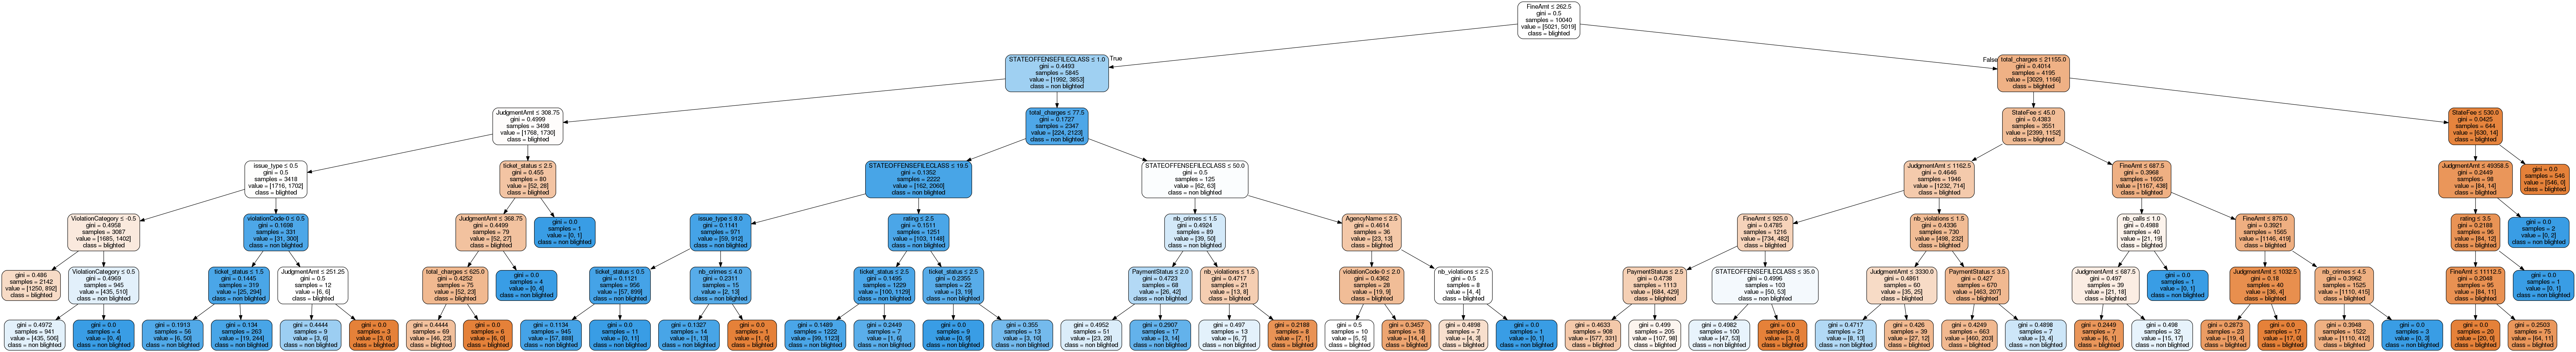

In [113]:
from IPython.display import Image  
from sklearn.externals.six import StringIO  
import pydot 

dot_data = StringIO()  
tree.export_graphviz(clf, out_file=dot_data,  
                         feature_names=feat_test.columns.values.tolist(),  
                         class_names=['blighted', 'non blighted'],  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = pydot.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())  

In [114]:
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]

print("Top features:")

col_labels = feat_test.columns.values.tolist()
for var in range(0, len(col_labels)):
    print("%d. %s (%f)" % (var, col_labels[var], importances[indices[var]]))

Top features:
0. CleanUpCost (0.463633)
1. FineAmt (0.307022)
2. nb_violations (0.092464)
3. AgencyName (0.078887)
4. JudgmentAmt (0.014614)
5. StateFee (0.013935)
6. violationCode-0 (0.012205)
7. ViolationCategory (0.004644)
8. PaymentStatus (0.004248)
9. rating (0.003289)
10. nb_calls (0.002283)
11. ticket_status (0.001081)
12. issue_type (0.001074)
13. STATEOFFENSEFILECLASS (0.000364)
14. nb_crimes (0.000256)
15. total_charges (0.000000)


### Results are a little bit better than the Naive aproach

## Randow forest classifier. Might be the right one.

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import cross_validation

model = RandomForestClassifier(n_estimators=10, max_features=5, max_depth=6)
model = model.fit(feat_train, out_train)

scores = cross_validation.cross_val_score(model, feat_train, out_train, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.72 (+/- 0.01)


In [11]:
forest_test_results = model.predict(feat_test)

In [12]:
accuracy_score(out_test, np.around(forest_test_results))

0.73147410358565734

In [13]:
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

print("Top features:")

col_labels = feat_test.columns.values.tolist()
for var in range(0, len(col_labels)):
    print("%d. %s (%f)" % (var, col_labels[var], importances[indices[var]]))

Top features:
0. CleanUpCost (0.268485)
1. FineAmt (0.219016)
2. nb_violations (0.091803)
3. AgencyName (0.090707)
4. JudgmentAmt (0.075536)
5. StateFee (0.075392)
6. violationCode-0 (0.048935)
7. ViolationCategory (0.044099)
8. PaymentStatus (0.022746)
9. rating (0.018151)
10. nb_calls (0.017838)
11. ticket_status (0.010091)
12. issue_type (0.010000)
13. STATEOFFENSEFILECLASS (0.005431)
14. nb_crimes (0.001667)
15. total_charges (0.000103)


## Interpretation

Both DecisionTree and RandomForest are tree analisys based.
That explain why the results are so near to each others.
They're quite good.
As you may observed, we limited the depth and the number of features to handle. That happend after some tests and it's more reasonable to deal with less features and depth than to try the impossible as an infinite depth for example.

### Last model

Let's try something different.
We'll study the SVM classifier.

In [25]:
from sklearn import svm

model = svm.SVC(decision_function_shape='ovo', kernel='rbf')
model = model.fit(feat_train, out_train)

scores = cross_validation.cross_val_score(model, feat_train, out_train, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.71 (+/- 0.02)


In [26]:
svm_test_results = model.predict(feat_test)

In [27]:
accuracy_score(out_test, np.around(svm_test_results))

0.71832669322709164

The support vector machines algorithm is quite good but may need a better features selection to perform by itself. That's where a decision tree is the best.


## Conclusion

### Project results analisys

The data used here is based on ~6k blighted buildings and a sample of ~6k non blighted buildings.
That means that to perform a better prediction model, we should select buildings with a maximum of informations.
__Because we can have a lot without any crimes, violations and 311 calls, which mean no features.__
Exclude all of those building could be an idea and also a big mistake. Because it's also important to be able to say that if a building without any damage can be blighted in the future if it's neighbourg is blighted a lot.
__That's a feauture that we didn't have integrated yet.__

That we know is if we change the non blighted data set a lot, we'll have different accuracies from our models.
It's like a cross validation process that we should have on data.

With our selected data, the main relevant features are:
0. CleanUpCost (0.179174)
1. FineAmt (0.159433)
2. nb_violations (0.156284)
3. AgencyName (0.117571)
4. JudgmentAmt (0.105058)
5. StateFee (0.101238)

Our best model seems to be a decision tree (as the random forest algorithm).
As our features importance show, we can definitly say that once we've at least one incident (violation) declared on one building, we could easily predict if it will be blighted or not.

The agency in charge of the problem is a clear indicator because it also define the nature of the problem. Each type of problem is associated to the correct legal proceedings.

Further step to improve this model is all about feature engineering.
In fact, we didnt' perform a great selection from violations (always took the last events, etc.). I'm sure that we can do better than that.

Integrate neighborhood data of a building is really something important and relevant that we should include in this project.


### Final

Finnaly, this project is really interesting and provide a lot of informations about how buildings live.
Some graphs for data interpretation could be a great stuff to have to decide or not what's important and find out how the algorithm selected the right features.

Let's do that in a next session.

Thanks for reading.
